In [6]:
import pandas as pd
import Levenshtein
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
from fuzzywuzzy import fuzz
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from transformers import BertForSequenceClassification, AdamW, BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
data = pd.read_json('../data/final_data/temp.jsonl', lines=True)

# No Context

In [9]:
deep_learning_no_context = data[['c1', 'c2', 'c1_embedding', 'c2_embedding', 'cosine_similarity', 'match']]

## LSTM Model with BERT Embedding

Preprocessing

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Membaca data ke dalam DataFrame (ganti dengan path Anda)
df = deep_learning_no_context.copy()

# Gabungkan embedding c1 dan c2 menjadi satu array sebagai input fitur
X = np.array([np.concatenate((np.array(c1), np.array(c2)), axis=1) for c1, c2 in zip(df['c1_embedding'], df['c2_embedding'])])

# Gunakan kolom 'match' sebagai label (target)
y = df['match'].values

# Split data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pastikan data dalam bentuk numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Cetak bentuk data untuk memastikan semuanya benar
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (18587, 1, 1536), y_train shape: (18587,)
X_test shape: (4647, 1, 1536), y_test shape: (4647,)


Buat model LSTM

In [11]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Hyperparameters
embedding_dim = 1536  # Dimensi embedding gabungan dari c1_embedding dan c2_embedding
lstm_dim = 64         # Jumlah unit pada LSTM
dense_dim = 64        # Jumlah unit pada Dense layer
batch_size = 32       # Ukuran batch
num_epochs = 10       # Jumlah epochs

# Callback Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Membangun model dengan Single LSTM
model = tf.keras.Sequential([
    # Single LSTM layer
    tf.keras.layers.LSTM(lstm_dim, input_shape=(None, embedding_dim)),
    
    # Fully connected Dense layer
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    
    # Output layer for binary classification
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Kompilasi model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melihat ringkasan model
model.summary()

# Melatih model dengan Early Stopping
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluasi model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                409856    
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 414,081
Trainable params: 414,081
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
581/581 [==============================] - 52s 39ms/step - loss: 0.6082 - accuracy: 0.6607 - val_loss: 0.6519 - val_accuracy: 0.6449
Epoch 2/10
581/581 [==============================] - 26s 45ms/step - loss: 0.5515 - accuracy: 0.7145 - val_loss: 0.5445 - val_accuracy: 0.7237
Epoch 3/10
581/581 [======

## Without BERT Embeddings

Konversi string menjadi representasi numerik dimulai dengan tokenization, di mana setiap kata dalam teks diubah menjadi token angka berdasarkan kamus yang dibuat dari data. Setelah itu, padding diterapkan untuk memastikan semua urutan token memiliki panjang yang sama. Token ini kemudian dimasukkan ke dalam embedding layer, yang mengonversi angka-angka tersebut menjadi vektor berdimensi tetap yang dapat dipelajari oleh model. Vektor-vektor ini memungkinkan model seperti LSTM untuk memahami pola dan hubungan semantik dalam data teks, sehingga model dapat membuat prediksi berdasarkan representasi numerik ini.

In [12]:
deep_learning_no_context = data[['c1', 'c2', 'match']]

In [13]:
deep_learning_no_context

,c1,c2,match
0,anz,ANZ,1
1,anz,Australian New Zealand Banking Group,1
2,anz,A.N.Z.,1
3,anz,ANZ Bank,1
4,anz,Anz,1
...,...,...,...
23229,aerotek,AeroVironment,0
23230,aerotek,Aeropostale,0
23231,michigan state university,Michigan Technological University,0
23232,michigan state university,Central Michigan University,0


In [14]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data dari dataframe
c1 = deep_learning_no_context['c1'].values
c2 = deep_learning_no_context['c2'].values
y = deep_learning_no_context['match'].values  # Label

# Hyperparameters
vocab_size = 10000   # Ukuran vocabulary untuk tokenizer
embedding_dim = 64   # Dimensi embedding
lstm_dim = 64        # Jumlah unit pada LSTM
max_length = 10      # Maksimal panjang sekuens setelah padding
padding_type = 'post'
oov_tok = "<OOV>"    # Token untuk kata yang tidak ada di tokenizer

# Tokenizer: mengubah string menjadi token
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(c1 + c2)  # Fit tokenizer pada teks c1 dan c2

# Mengubah c1 dan c2 menjadi token sequences
c1_sequences = tokenizer.texts_to_sequences(c1)
c2_sequences = tokenizer.texts_to_sequences(c2)

# Padding sequences untuk membuat panjang sekuens sama
c1_padded = pad_sequences(c1_sequences, maxlen=max_length, padding=padding_type)
c2_padded = pad_sequences(c2_sequences, maxlen=max_length, padding=padding_type)

# Gabungkan c1 dan c2 menjadi satu input untuk model
X = np.hstack([c1_padded, c2_padded])

# Split data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (18587, 20), y_train shape: (18587,)
X_test shape: (4647, 20), y_test shape: (4647,)


In [15]:
# Membangun model dengan LSTM
model = tf.keras.Sequential([
    # Embedding layer
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=X_train.shape[1]),
    
    # LSTM layer
    tf.keras.layers.LSTM(lstm_dim),
    
    # Fully connected Dense layer
    tf.keras.layers.Dense(64, activation='relu'),
    
    # Dropout layer untuk regularisasi
    tf.keras.layers.Dropout(0.5),
    
    # Output layer untuk binary classification
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Callback Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Kompilasi model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melihat ringkasan model
model.summary()

# Melatih model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluasi model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 64)            640000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 677,249
Trainable params: 677,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
581/581 [============================

# With Context

## With BERT Embeddings

In [16]:
deep_learning_with_context = data[['c1_context_embedding', 'c2_context_embedding', 'c1_embedding', 'c2_embedding', 'match']]

In [17]:
# Misalnya, periksa shape dari c1_embedding di baris pertama
print(f"Shape of c1_embedding at index 0: {np.array(deep_learning_with_context['c1_embedding'][0]).shape}")

# Periksa shape dari c2_embedding di baris pertama
print(f"Shape of c2_embedding at index 0: {np.array(deep_learning_with_context['c2_embedding'][0]).shape}")

# Periksa shape dari c1_context_embedding di baris pertama
print(f"Shape of c1_context_embedding at index 0: {np.array(deep_learning_with_context['c1_context_embedding'][0]).shape}")

# Periksa shape dari c2_context_embedding di baris pertama
print(f"Shape of c2_context_embedding at index 0: {np.array(deep_learning_with_context['c2_context_embedding'][0]).shape}")


Shape of c1_embedding at index 0: (1, 768)
Shape of c2_embedding at index 0: (1, 768)
Shape of c1_context_embedding at index 0: (1, 768)
Shape of c2_context_embedding at index 0: (1, 768)


In [18]:
# Gabungkan context embedding dan original embedding
X = np.array([np.concatenate((np.array(c1), np.array(c2), np.array(c1_context), np.array(c2_context)), axis=0) 
              for c1, c2, c1_context, c2_context in zip(deep_learning_with_context['c1_embedding'], deep_learning_with_context['c2_embedding'], deep_learning_with_context['c1_context_embedding'], deep_learning_with_context['c2_context_embedding'])])


# Gunakan kolom 'match' sebagai label (target)
y = deep_learning_with_context['match'].values

# Split data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pastikan data dalam bentuk numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Cetak bentuk data untuk memastikan semuanya benar
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (18587, 4, 768), y_train shape: (18587,)
X_test shape: (4647, 4, 768), y_test shape: (4647,)


In [19]:
# Hyperparameters
lstm_dim = 128        # Jumlah unit pada LSTM
dense_dim = 64       # Jumlah unit pada Dense layer
batch_size = 32      # Ukuran batch
num_epochs = 30      # Jumlah epochs

# Callback Early 
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Membangun model dengan LSTM (menggunakan Sequential API)
model = tf.keras.Sequential([
    # LSTM layer untuk memproses sequence dengan 4 timesteps dan 768 features
    tf.keras.layers.LSTM(lstm_dim, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),

    # LSTM kedua
    tf.keras.layers.LSTM(lstm_dim),
    
    # Fully connected Dense layer
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    
    # Dropout layer untuk regularisasi
    tf.keras.layers.Dropout(0.5),
    
    # Output layer untuk binary classification
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Coba BI-LSTM (Akurasi gak naik)
# model = tf.keras.Sequential([    
#     # Bidirectional LSTM pertama
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    
#     # Bidirectional LSTM kedua
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    
#     # Fully connected Dense layer
#     tf.keras.layers.Dense(dense_dim, activation='relu'),
    
#     # Dropout layer untuk regularisasi
#     tf.keras.layers.Dropout(0.5),
    
#     # Output layer untuk binary classification
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])


# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# Kompilasi model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melihat ringkasan model
model.summary()

# Callback Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Melatih model dengan Early Stopping
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluasi model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4, 128)            459264    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 599,169
Trainable params: 599,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
581/581 [============================

## Without BERT Embeddings

In [20]:
deep_learning_with_context = data[['c1_context', 'c2_context', 'c1', 'c2', 'match']]

In [21]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Concatenate

# Data dari dataframe
c1 = deep_learning_with_context['c1'].values
c2 = deep_learning_with_context['c2'].values
c1_context = deep_learning_with_context['c1_context'].values  # Kolom context string untuk c1
c2_context = deep_learning_with_context['c2_context'].values  # Kolom context string untuk c2
y = deep_learning_with_context['match'].values  # Label

# Hyperparameters
vocab_size = 10000   # Ukuran vocabulary untuk tokenizer
embedding_dim = 64   # Dimensi embedding
lstm_dim = 64        # Jumlah unit pada LSTM
max_length = 10      # Maksimal panjang sekuens setelah padding
padding_type = 'post'
oov_tok = "<OOV>"    # Token untuk kata yang tidak ada di tokenizer

# Tokenizer: mengubah string menjadi token
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(np.concatenate((c1, c2, c1_context, c2_context)))  # Fit tokenizer pada teks c1, c2, c1_context, dan c2_context

# Mengubah c1, c2, c1_context, dan c2_context menjadi token sequences
c1_sequences = tokenizer.texts_to_sequences(c1)
c2_sequences = tokenizer.texts_to_sequences(c2)
c1_context_sequences = tokenizer.texts_to_sequences(c1_context)
c2_context_sequences = tokenizer.texts_to_sequences(c2_context)

# Padding sequences untuk membuat panjang sekuens sama
c1_padded = pad_sequences(c1_sequences, maxlen=max_length, padding=padding_type)
c2_padded = pad_sequences(c2_sequences, maxlen=max_length, padding=padding_type)
c1_context_padded = pad_sequences(c1_context_sequences, maxlen=max_length, padding=padding_type)
c2_context_padded = pad_sequences(c2_context_sequences, maxlen=max_length, padding=padding_type)

# Split data menjadi train dan test set
X_train_c1, X_test_c1, X_train_c2, X_test_c2, X_train_c1_context, X_test_c1_context, X_train_c2_context, X_test_c2_context, y_train, y_test = train_test_split(
    c1_padded, c2_padded, c1_context_padded, c2_context_padded, y, test_size=0.2, random_state=42)

# Gabungkan semua fitur menjadi satu array besar
X_combined = np.concatenate([c1_padded, c2_padded, c1_context_padded, c2_context_padded], axis=1)

# Split data menjadi train dan test set sekaligus
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (18587, 40), y_train shape: (18587,)
X_test shape: (4647, 40), y_test shape: (4647,)


In [22]:
# Membangun model dengan multiple input LSTM
# Input untuk c1
input_c1 = Input(shape=(max_length,))
embedding_c1 = Embedding(vocab_size, embedding_dim)(input_c1)
lstm_c1 = LSTM(lstm_dim)(embedding_c1)

# Input untuk c2
input_c2 = Input(shape=(max_length,))
embedding_c2 = Embedding(vocab_size, embedding_dim)(input_c2)
lstm_c2 = LSTM(lstm_dim)(embedding_c2)

# Input untuk c1_context
input_c1_context = Input(shape=(max_length,))
embedding_c1_context = Embedding(vocab_size, embedding_dim)(input_c1_context)
lstm_c1_context = LSTM(lstm_dim)(embedding_c1_context)

# Input untuk c2_context
input_c2_context = Input(shape=(max_length,))
embedding_c2_context = Embedding(vocab_size, embedding_dim)(input_c2_context)
lstm_c2_context = LSTM(lstm_dim)(embedding_c2_context)

# Gabungkan hasil embedding dari c1, c2, c1_context, dan c2_context
merged = Concatenate()([lstm_c1, lstm_c2, lstm_c1_context, lstm_c2_context])

# Fully connected Dense layer
dense = Dense(64, activation='relu')(merged)

# Dropout untuk regularisasi
dropout = Dropout(0.5)(dense)

# Output layer untuk binary classification
output = Dense(1, activation='sigmoid')(dropout)

# Membangun dan menggabungkan model
model = tf.keras.Model(inputs=[input_c1, input_c2, input_c1_context, input_c2_context], outputs=output)

# Callback Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Kompilasi model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melihat ringkasan model
model.summary()

# Melatih model
history = model.fit([X_train_c1, X_train_c2, X_train_c1_context, X_train_c2_context], y_train, epochs=10, batch_size=32,
                    validation_data=([X_test_c1, X_test_c2, X_test_c1_context, X_test_c2_context], y_test), callbacks=[early_stopping])

# Evaluasi model
test_loss, test_acc = model.evaluate([X_test_c1, X_test_c2, X_test_c1_context, X_test_c2_context], y_test)
print(f'Test Accuracy: {test_acc}')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 10)]         0           []                               
                                                                                              

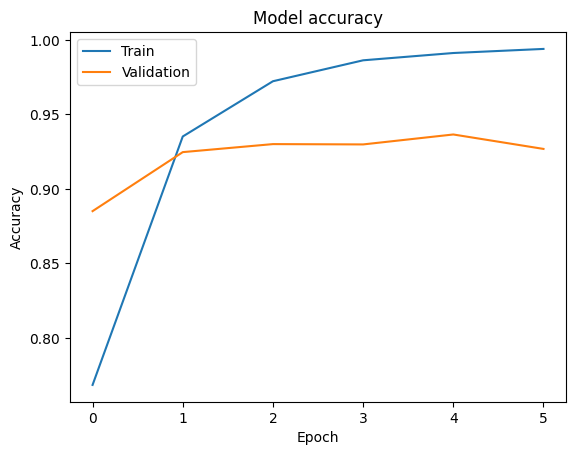

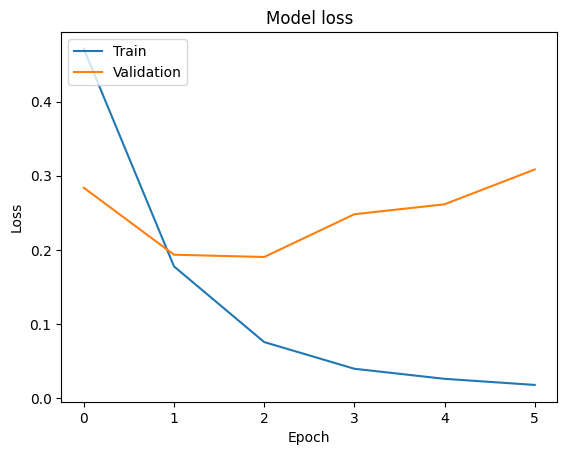

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
